In [1]:
import sys
sys.path.append("..")

import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
import numpyro
from numpyro import distributions as dist
from numpyro import infer

from numpyro_ext import distributions as distx
from numpyro_ext import info, optim

jax.config.update("jax_enable_x64", True)
numpyro.set_host_device_count(2)

from jaxoplanet import light_curves, orbits
import arviz as az
import corner

from core.jax import oblate_lightcurve

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


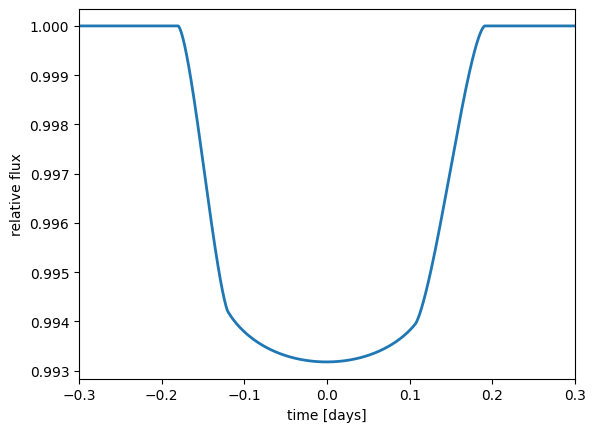

In [2]:
#Fiducial planet parameters:
params = {'period':300.456,
          'radius':0.1,
          'u':jnp.array([0.3,0.2]),
          'f':0.3,
          'bo':0.8,
          'theta':jnp.radians(35)
}
# The light curve calculation requires an orbit

# Compute a limb-darkened light curve using starry
t = jnp.linspace(-0.3, 0.3, 1000)
oblate_lightcurve = jit(oblate_lightcurve)
lc = oblate_lightcurve(params,t)

plt.plot(t, lc/lc[0], color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())